In [152]:
pip install mysql-connector-python

In [288]:
import mysql.connector
import sqlalchemy
from sqlalchemy import create_engine

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import plotly.express as px
import pymysql

In [289]:
import warnings
warnings.filterwarnings('ignore')

In [290]:
db = mysql.connector.connect(
        host='localhost',
        user='root',
        password='1234',
        database='sprint4'
)

cursor = db.cursor()

# Traer todas las tablas de la base
cursor.execute("SHOW TABLES")
tablas_mysql = cursor.fetchall()

# Crear diccionario
dfs = {}

# Recorro las tablas dinámicamente
for tabla in tablas_mysql:
    nombre_tabla = tabla[0]  # El fetchall trae tuplas, saco el nombre
    dfs[f'df_{nombre_tabla}'] = pd.read_sql(f"SELECT * FROM {nombre_tabla}", con=db)

# Ver las claves
print(dfs.keys())
#para llamar a los df tengo que hacer dfs['df_nombre']

dict_keys(['df_actives_cards', 'df_companies', 'df_credit_cards', 'df_productos_vendidos', 'df_products', 'df_transactions', 'df_users'])


#compruebo que no haya duplicados:
def data_info(df):
   
    """Input: dataframe.
    Function displays basic information, 
    checks for duplicates and NaN. 
    """
    
    # get first and last 5 rows
    display(df)
    
    # get information about the data
    print()
    print(df.info())
    
    # number of unique values for each column
    print()
    print('\033[1mNumber of unique values')
    display(df.nunique())
    
    # check for duplicates (without id columns)
    print()
    if df.iloc[:,1:].duplicated().sum() > 0:
        print('Data contain full duplicates\n')
    else:
        print('There are no full duplicates in the data\n')
    
    # check for NaN
    if df.isna().sum().sum() > 0:
        print('Data contain NaN\n')
    else:
        print('There are no NaNs in the data\n')

for tabel in dfs:
    print(f'\033[1m{tabel.upper()}')
    print('_____________________')
    data_info(dfs[tabel])

In [291]:
dfs['df_products']

,id,product_name,price,colour,weight,warehouse_id
0,1,Direwolf Stannis,$161.11,#7c7c7c,1.0,WH-4
1,10,Karstark Dorne,$119.52,#f4f4f4,2.4,WH--5
2,100,south duel,$40.43,#6d6d6d,3.0,WH--95
3,11,Karstark Dorne,$49.70,#141414,2.7,WH--6
4,12,duel Direwolf,$181.60,#a8a8a8,2.1,WH--7
...,...,...,...,...,...,...
95,95,riverlands north Direwolf,$6.90,#c1c1c1,2.7,WH--90
96,96,dooku solo,$20.92,#282828,2.1,WH--91
97,97,jinn Winterfell,$65.25,#bababa,1.0,WH--92
98,98,Direwolf Littlefinger,$38.33,#bababa,2.0,WH--93


## LIMPIO

In [292]:
# Elimino de la tabla products el dolar en la columna 'price' y la transformo en float
# Eliminar el símbolo '$' y convertir a float, manejando posibles valores nulos o errores
dfs['df_products']['price'] = dfs['df_products']['price'].str.replace('$', '', regex=False).astype(float)
dfs['df_products'].head()


,id,product_name,price,colour,weight,warehouse_id
0,1,Direwolf Stannis,161.11,#7c7c7c,1.0,WH-4
1,10,Karstark Dorne,119.52,#f4f4f4,2.4,WH--5
2,100,south duel,40.43,#6d6d6d,3.0,WH--95
3,11,Karstark Dorne,49.70,#141414,2.7,WH--6
4,12,duel Direwolf,181.60,#a8a8a8,2.1,WH--7


In [293]:
# Convertimos 'birth_day' a tipo datetime, como en powerbi
dfs['df_users']['birth_date'] = pd.to_datetime(dfs['df_users']['birth_date'])

# Función para calcular la edad
from datetime import date

def calculo_edad(birth_date):
    today = date.today()  # Fecha actual
    return today.year - birth_date.year - ((today.month, today.day) < (birth_date.month, birth_date.day)) 
# Creamos la columna 'edad'
dfs['df_users']['edad'] = dfs['df_users']['birth_date'].apply(calculo_edad)

print(dfs['df_users']['edad'].head())

print(dfs['df_users'].head())


0    39
1    41
2    35
3    42
4    43
Name: edad, dtype: int64
    id     name   surname           phone                         email  \
0    1     Zeus    Gamble  1-282-581-0551  interdum.enim@protonmail.edu   
1   10   Robert  Mccarthy  (324) 746-6771      fermentum@protonmail.com   
2  100  Melodie    Mclean  1-677-221-7152        risus.varius@google.ca   
3  101    Sarah      Beck  (358) 691-4345          vitae.risus@aol.couk   
4  102   Jasper    Landry  1-397-765-1118  consectetuer.euismod@aol.org   

  birth_date        country         city postal_code  \
0 1985-11-17  United States       Lowell       73544   
1 1984-04-30  United States       Eugene       85526   
2 1989-09-15  United States      College       11838   
3 1983-04-09  United States  Great Falls       67129   
4 1982-04-16  United States     Columbus       11595   

                         address  edad  
0          348-7818 Sagittis St.    39  
1  P.O. Box 773, 3594 Ornare St.    41  
2      Ap #644-8492 Sagi

In [294]:
#crear columna año y día de la semana, como power bi:
#creamos columna fecha y la convierto en formato datetime
dfs['df_transactions']['fecha'] = dfs['df_transactions']['timestamp'].dt.date

dfs['df_transactions']['fecha'] = pd.to_datetime(dfs['df_transactions']['fecha'])

dfs['df_transactions']['fecha'].info()


#columna year
dfs['df_transactions']['Year'] = dfs['df_transactions']['fecha'].dt.strftime('%Y')

dfs['df_transactions']['Year']

#columna día de la semana
dfs['df_transactions']['Day'] =  dfs['df_transactions']['fecha'].dt.strftime('%A')

dfs['df_transactions']['Day'] 


<class 'pandas.core.series.Series'>
RangeIndex: 587 entries, 0 to 586
Series name: fecha
Non-Null Count  Dtype         
--------------  -----         
587 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 4.7 KB


0       Saturday
1         Monday
2       Thursday
3      Wednesday
4        Tuesday
         ...    
582       Sunday
583    Wednesday
584       Sunday
585      Tuesday
586      Tuesday
Name: Day, Length: 587, dtype: object

In [295]:
dfs['df_companies']['phone'] = dfs['df_companies']['phone'].astype(str)
dfs['df_companies']

,company_id,company_name,phone,email,country,website
0,b-2222,Ac Fermentum Incorporated,06 85 56 52 33,donec.porttitor.tellus@yahoo.net,Germany,https://instagram.com/site
1,b-2226,Magna A Neque Industries,04 14 44 64 62,risus.donec.nibh@icloud.org,Australia,https://whatsapp.com/group/9
2,b-2230,Fusce Corp.,08 14 97 58 85,risus@protonmail.edu,United States,https://pinterest.com/sub/cars
3,b-2234,Convallis In Incorporated,06 66 57 29 50,mauris.ut@aol.couk,Germany,https://cnn.com/user/110
4,b-2238,Ante Iaculis Nec Foundation,08 23 04 99 53,sed.dictum.proin@outlook.ca,New Zealand,https://netflix.com/settings
...,...,...,...,...,...,...
95,b-2602,Placerat LLP,05 43 67 24 41,tellus.suspendisse@hotmail.org,Netherlands,https://zoom.us/sub
96,b-2606,Sed Est Corp.,04 58 02 37 91,tempor.bibendum@google.couk,Canada,https://instagram.com/sub/cars
97,b-2610,Egestas Nunc Sed Limited,06 01 02 70 47,vitae@hotmail.edu,Italy,https://walmart.com/one
98,b-2614,Rutrum Non Inc.,02 66 31 61 09,neque@protonmail.net,Germany,https://netflix.com/site


In [296]:
dfs['df_companies']['country'] = dfs['df_companies']['country'].astype('str')
dfs['df_companies']['website'] = dfs['df_companies']['website'].astype('str')
dfs['df_companies']['email'] = dfs ['df_companies']['email'].astype('str')
dfs['df_companies']['company_name'] = dfs['df_companies']['company_name'].astype('str')
dfs['df_companies']['company_id'] = dfs['df_companies']['company_id'].str.replace('b-', '').astype('str')
dfs['df_transactions']['business_id'] = dfs['df_transactions']['business_id'].str.replace('b-', '')

In [297]:
dfs['df_companies'].info()
dfs['df_actives_cards'].info()
dfs['df_credit_cards'].info()
dfs['df_productos_vendidos'].info() 
dfs['df_products'].info() 
dfs['df_transactions'].info() 
dfs['df_users'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_id    100 non-null    object
 1   company_name  100 non-null    object
 2   phone         100 non-null    object
 3   email         100 non-null    object
 4   country       100 non-null    object
 5   website       100 non-null    object
dtypes: object(6)
memory usage: 4.8+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   card_id   0 non-null      object
 1   declined  0 non-null      object
dtypes: object(2)
memory usage: 0.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275 entries, 0 to 274
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             275 non-null    object
 1   u

In [298]:
dfs['df_transactions']['declined'] = dfs['df_transactions']['declined'].astype(int).astype(bool)

In [299]:
dfs['df_transactions'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 587 entries, 0 to 586
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           587 non-null    object        
 1   card_id      587 non-null    object        
 2   business_id  587 non-null    object        
 3   timestamp    587 non-null    datetime64[ns]
 4   amount       587 non-null    float64       
 5   declined     587 non-null    bool          
 6   product_ids  587 non-null    object        
 7   user_id      587 non-null    object        
 8   lat          587 non-null    object        
 9   longitude    587 non-null    object        
 10  fecha        587 non-null    datetime64[ns]
 11  Year         587 non-null    object        
 12  Day          587 non-null    object        
dtypes: bool(1), datetime64[ns](2), float64(1), object(9)
memory usage: 55.7+ KB


### EXERCICI 1
Una variable numérica:


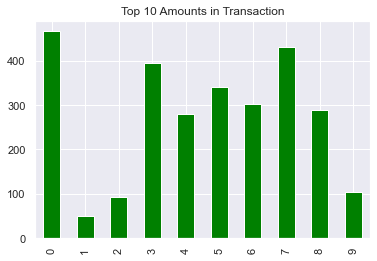

In [300]:
dfs['df_transactions']['amount'].head(10).plot(kind='bar', title='Top 10 Amounts in Transaction', color='green')
plt.show()

### EXERCICI 2
dos variables numericas

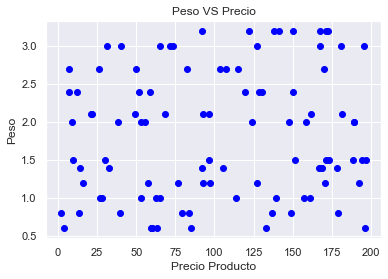

In [301]:
precio = dfs['df_products']['price']
peso = dfs['df_products']['weight']

plt.scatter(x=precio, y=peso, color='blue')
plt.xlabel('Precio Producto')
plt.ylabel('Peso')
plt.title("Peso VS Precio")
plt.show()


### EXERCICI 3
Una variable categòrica

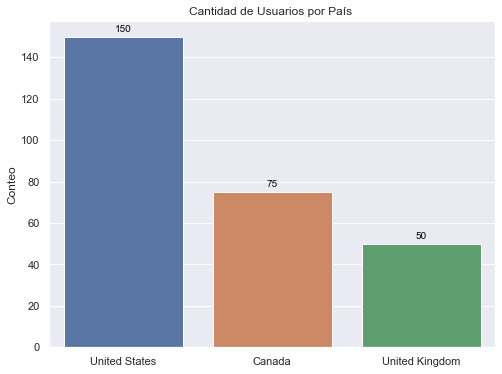

In [302]:
order = dfs['df_users']['country'].value_counts().index

plt.figure(figsize = (8,6))
ax = sns.countplot(data=dfs['df_users'], x="country", order=order)
ax.set_xlabel('')
ax.set_ylabel('Conteo')
ax.set_title('Cantidad de Usuarios por País ')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', 
                fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.show()


### EXERCICI 4
Una variable categòrica i una numèrica:

In [303]:
#Ingresos por país:

#merge
transactions_companies = dfs['df_transactions'].merge(dfs['df_companies'], left_on='business_id', right_on='company_id')

print(transactions_companies[['business_id', 'company_id', 'company_name', 'country']].head())



  business_id company_id           company_name country
0        2362       2362  Lorem Eu Incorporated  Canada
1        2362       2362  Lorem Eu Incorporated  Canada
2        2362       2362  Lorem Eu Incorporated  Canada
3        2362       2362  Lorem Eu Incorporated  Canada
4        2362       2362  Lorem Eu Incorporated  Canada


In [304]:
print(dfs['df_transactions']['business_id'].unique()[:5])
print(dfs['df_companies']['company_id'].unique()[:5])

['2362' '2302' '2250' '2618' '2346']
['2222' '2226' '2230' '2234' '2238']


In [305]:
transactions_companies = dfs['df_transactions'].merge(dfs['df_companies'], left_on='business_id', right_on='company_id', 
                                                      how='left')

print(transactions_companies[['business_id', 'company_id', 'company_name', 'country']].head())


  business_id company_id                  company_name         country
0        2362       2362         Lorem Eu Incorporated          Canada
1        2302       2302    Nunc Interdum Incorporated         Germany
2        2250       2250  Amet Nulla Donec Corporation           Italy
3        2618       2618                 Non Institute  United Kingdom
4        2346       2346          Ut Semper Foundation          Sweden


In [306]:
transactions_companies = dfs['df_transactions'].merge(
    dfs['df_companies'][['company_id', 'country']], 
    left_on='business_id', 
    right_on='company_id',
    how='left'
)
transactions_companies

,id,card_id,business_id,timestamp,amount,declined,product_ids,user_id,lat,longitude,fecha,Year,Day,company_id,country
0,02C6201E-D90A-1859-B4EE-88D2986D3B02,CcU-2938,2362,2021-08-28 23:42:24,466.92,False,"71, 1, 19",92,81.9184589824,-12.5275561984,2021-08-28,2021,Saturday,2362,Canada
1,0466A42E-47CF-8D24-FD01-C0B689713128,CcU-4219,2302,2021-07-26 07:29:18,49.53,False,"47, 97, 43",170,-43.9694885888,-117.5251835904,2021-07-26,2021,Monday,2302,Germany
2,063FBA79-99EC-66FB-29F7-25726D1764A5,CcU-2987,2250,2022-01-06 21:25:27,92.61,False,"47, 67, 31, 5",275,-81.222680576,-129.049879552,2022-01-06,2022,Thursday,2250,Italy
3,0668296C-CDB9-A883-76BC-2E4C44F8C8AE,CcU-3743,2618,2022-01-26 02:07:14,394.18,False,"89, 83, 79",265,-34.3593055232,-100.555928064,2022-01-26,2022,Wednesday,2618,United Kingdom
4,06CD9AA5-9B42-D684-DDDD-A5E394FEBA99,CcU-2959,2346,2021-10-26 23:00:01,279.93,False,"43, 31",92,33.7381445632,158.298210304,2021-10-26,2021,Tuesday,2346,Sweden
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
582,FD2E8957-414B-BEEC-E9AD-59AA7A8A6290,CcU-3232,2390,2022-03-13 00:27:34,78.29,False,"83, 7, 17, 89",272,-24.3194717184,-11.4134912,2022-03-13,2022,Sunday,2390,Ireland
583,FD89D51B-AE8D-77DC-E450-B8083FBD3187,CcU-3960,2494,2022-03-16 02:35:05,200.72,False,"3, 2, 73, 1",250,8.012168192,-64.671543808,2022-03-16,2022,Wednesday,2494,Ireland
584,FD9CBCCD-8E1E-8DA1-4606-7E3A6F3A5A65,CcU-4331,2302,2021-06-13 11:41:17,42.32,False,37,223,-77.8604531712,-172.3457293312,2021-06-13,2021,Sunday,2302,Germany
585,FE809ED4-2DB6-55AC-C915-929516E4646B,CcU-4849,2302,2021-11-09 21:35:40,219.83,False,"23, 43",185,-46.0751433728,-142.2416956416,2021-11-09,2021,Tuesday,2302,Germany


In [307]:
tr_pais = transactions_companies[transactions_companies['declined'] == 0]
tr_pais = tr_pais.groupby('country')['amount'].sum().reset_index()
tr_pais = tr_pais.sort_values('amount', ascending=False)
print(tr_pais)

           country    amount
5          Germany  26888.55
13  United Kingdom  25274.38
12          Sweden  18813.45
6          Ireland  16006.22
10          Norway  15318.01
2           Canada  14930.69
14   United States   2587.78
8      Netherlands   2409.40
7            Italy   2190.08
1          Belgium   2041.74
0        Australia   1063.99
9      New Zealand   1002.37
4           France    508.23
3            China    444.48
11           Spain     26.22


In [308]:
print(transactions_companies[['id', 'amount', 'declined', 'country']].head(10))

                                     id  amount  declined         country
0  02C6201E-D90A-1859-B4EE-88D2986D3B02  466.92     False          Canada
1  0466A42E-47CF-8D24-FD01-C0B689713128   49.53     False         Germany
2  063FBA79-99EC-66FB-29F7-25726D1764A5   92.61     False           Italy
3  0668296C-CDB9-A883-76BC-2E4C44F8C8AE  394.18     False  United Kingdom
4  06CD9AA5-9B42-D684-DDDD-A5E394FEBA99  279.93     False          Sweden
5  07A46D48-31A3-7E87-65B9-0DA902AD109F  340.87      True   United States
6  09DE92CE-6F27-2BB7-13B5-9385B2B3B8E2  303.05      True          Canada
7  0A476ED9-0C13-1962-F87B-D3563924B539  430.49     False         Germany
8  0BEB80B7-9D66-1707-CE4B-9DC7E71914B5  288.81      True     New Zealand
9  0C7C3A33-9947-3BC1-846D-7BE3D0D17598  103.44      True          Sweden


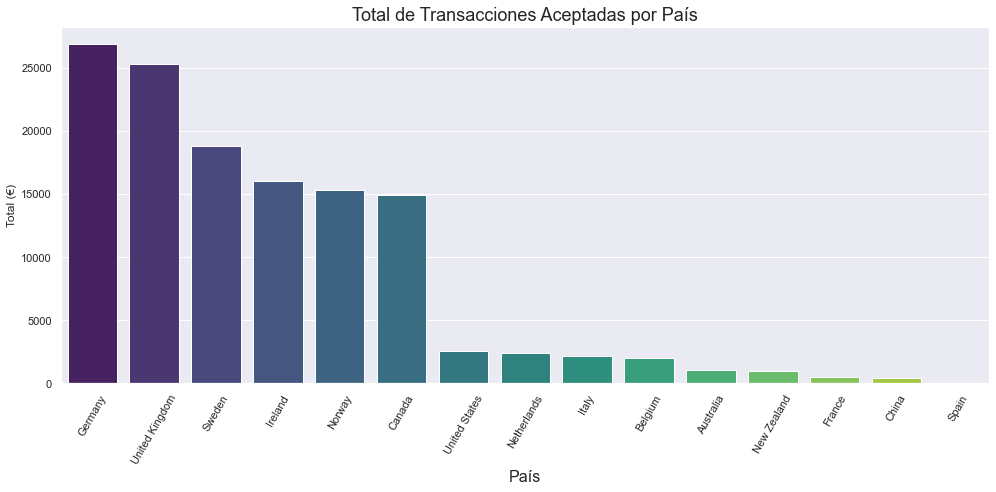

In [309]:
plt.figure(figsize=(14,7))
sns.barplot(data=tr_pais, x='country', y='amount', palette='viridis')
plt.title('Total de Transacciones Aceptadas por País', fontsize=18)
plt.xlabel('País', fontsize=16)
plt.ylabel('Total (€)')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

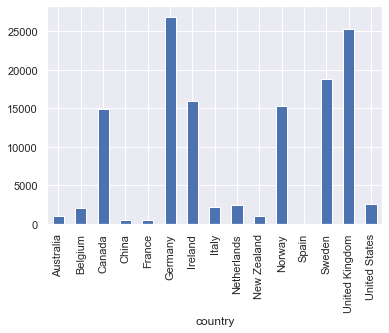

In [310]:
tr_pais = tr_pais.groupby('country')['amount'].mean().plot.bar()
#més senzill

In [311]:
#Limpiamos columnas de IDs
dfs['df_transactions']['business_id'] = dfs['df_transactions']['business_id'].str.replace('b-', '').str.strip()
dfs['df_companies']['company_id'] = dfs['df_companies']['company_id'].str.strip()

In [312]:
#Comprobamos la agrupación
tr_país = transactions_companies.groupby('country')['amount'].sum().reset_index()
print(tr_país.head())  # Muestra las primeras filas del DataFrame agrupado


     country    amount
0  Australia   2784.63
1    Belgium   2965.92
2     Canada  16448.52
3      China    682.67
4     France   1075.19


In [313]:
# Verificamos si hay valores NaN en la columna 'country'
print(tr_país['country'].isna().sum()) 

0


In [314]:
#Eliminamos filas con valores nulos en la columna 'country'
tr_país = tr_país.dropna(subset=['country'])


<class 'pandas.core.frame.DataFrame'>
           country    amount
5          Germany  26888.55
13  United Kingdom  25274.38
12          Sweden  18813.45
6          Ireland  16006.22
10          Norway  15318.01


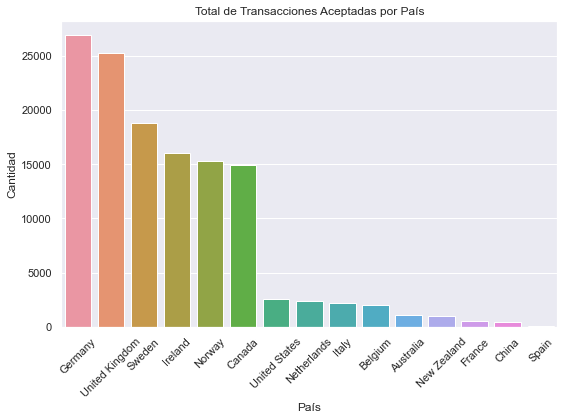

In [316]:
tr_pais = transactions_companies[transactions_companies['declined'] == 0]
tr_pais = tr_pais.groupby('country')['amount'].sum().reset_index()
tr_pais = tr_pais.sort_values('amount', ascending=False)

print(type(tr_pais)) 
print(tr_pais.head())  

plt.figure(figsize=(8, 6))
sns.barplot(data=tr_pais, x='country', y='amount')
plt.title('Total de Transacciones Aceptadas por País')
plt.xlabel('País')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [317]:
print(tr_país.dtypes)

tr_país['amount'] = pd.to_numeric(tr_país['amount'], errors='coerce')

tr_país['country'] = tr_país['country'].astype(str)


country     object
amount     float64
dtype: object


In [318]:
print(tr_país['amount'].isna().sum())
tr_país = tr_país.dropna(subset=['amount'])
#para comprobar valores duplicados

0


In [319]:
# Eliminamos el dolar en 'price' y cambiamos a float
dfs['df_products']['price'] = dfs['df_products']['price'].replace('$','').astype(float)
dfs['df_products']

,id,product_name,price,colour,weight,warehouse_id
0,1,Direwolf Stannis,161.11,#7c7c7c,1.0,WH-4
1,10,Karstark Dorne,119.52,#f4f4f4,2.4,WH--5
2,100,south duel,40.43,#6d6d6d,3.0,WH--95
3,11,Karstark Dorne,49.70,#141414,2.7,WH--6
4,12,duel Direwolf,181.60,#a8a8a8,2.1,WH--7
...,...,...,...,...,...,...
95,95,riverlands north Direwolf,6.90,#c1c1c1,2.7,WH--90
96,96,dooku solo,20.92,#282828,2.1,WH--91
97,97,jinn Winterfell,65.25,#bababa,1.0,WH--92
98,98,Direwolf Littlefinger,38.33,#bababa,2.0,WH--93


### EXERCICI 5
Dues variables categòriques:

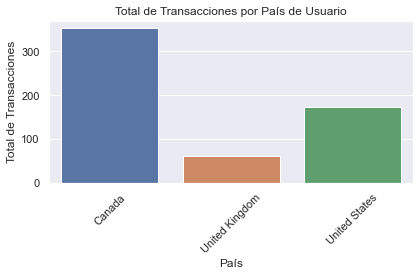

In [320]:
transactions_users = dfs['df_transactions'].merge(dfs['df_users'][['id', 'country']], left_on='user_id', right_on='id', suffixes=('', '_user'))
trans_country = transactions_users.groupby('country').size().reset_index(name='total_transactions')

sns.barplot(data=trans_country, x='country', y='total_transactions')
plt.title('Total de Transacciones por País de Usuario')
plt.xlabel('País')
plt.ylabel('Total de Transacciones')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### EXERCICI 6
Tres variables


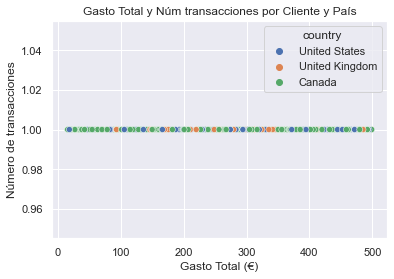

In [321]:
#está mal este
#Scatter plot (Cuantas transacciones y gasto total) 
#no me sale bien, mirar bien el merge o las variables.

bubble_chart= dfs['df_transactions']
bubble_chart = pd.merge(bubble_chart[['id','user_id','amount']], dfs['df_users'][['id','country']], left_on= 'user_id', right_on= 'id')

bubble_chart = bubble_chart.drop('id_y', axis = 1)

bubble_chart = bubble_chart.rename(columns={'id_x':'id'})

bubble_chart_grouped = bubble_chart.groupby('id').agg(
    total_amount=('amount', 'sum'),
    total_trans= ('id', 'count'),
    country = ('country','first')
).reset_index()
bubble_chart_grouped = bubble_chart_grouped.dropna(subset=['country'])
sns.set_theme(style="darkgrid")

sns.scatterplot(
    data= bubble_chart_grouped,
    x="total_amount",
    y="total_trans",
    hue= "country")
plt.title('Gasto Total y Núm transacciones por Cliente y País')
plt.xlabel('Gasto Total (€)')
plt.ylabel('Número de transacciones')
plt.show()


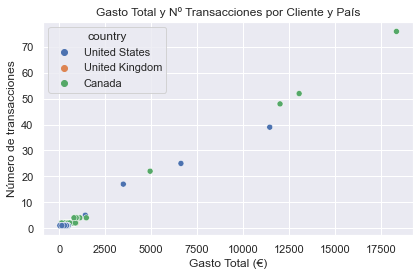

In [322]:
bubble_chart = dfs['df_transactions'][['id', 'user_id', 'amount']].copy()
bubble_chart = bubble_chart.merge(
    dfs['df_users'][['id', 'country']],
    left_on='user_id',
    right_on='id',
    suffixes=('_transaction', '_user')
)
# eliminamos el id duplicado
bubble_chart = bubble_chart.drop(columns='id_user')
bubble_chart = bubble_chart.rename(columns={'id_transaction': 'transaction_id'})

bubble_chart_grouped = bubble_chart.groupby('user_id').agg(
    total_amount=('amount', 'sum'),
    total_trans=('transaction_id', 'count'),
    country=('country', 'first')
).reset_index()

bubble_chart_grouped = bubble_chart_grouped.dropna(subset=['country'])

sns.set_theme(style="darkgrid")

sns.scatterplot(
    data=bubble_chart_grouped,
    x="total_amount",
    y="total_trans",
    hue="country"
)

plt.title('Gasto Total y Nº Transacciones por Cliente y País')
plt.xlabel('Gasto Total (€)')
plt.ylabel('Número de transacciones')
plt.tight_layout()
plt.show()



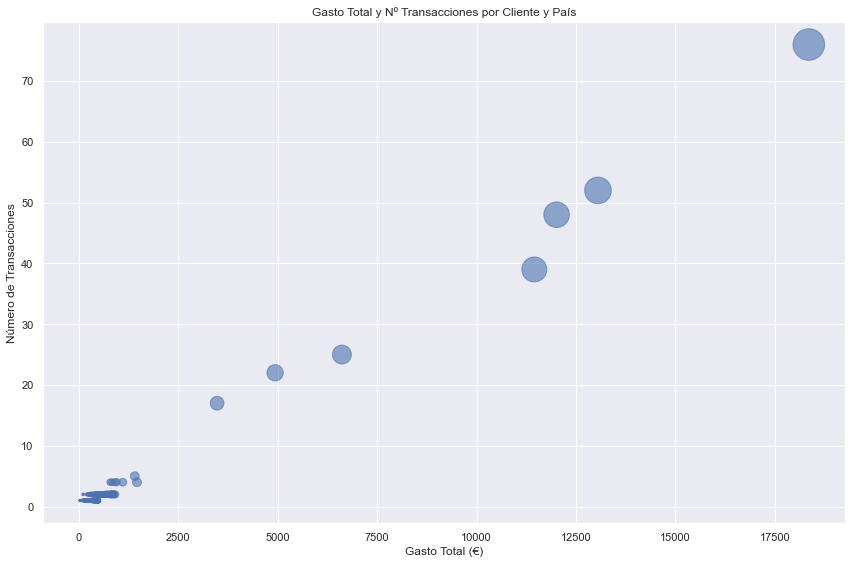

In [330]:
bubble_chart = dfs['df_transactions'][['id', 'user_id', 'amount']].copy()

#país del usuario
bubble_chart = bubble_chart.merge(
    dfs['df_users'][['id', 'country']],
    left_on='user_id',
    right_on='id',
    suffixes=('_transaction', '_user')
)

#columna duplicada
bubble_chart = bubble_chart.drop(columns='id_user')
bubble_chart = bubble_chart.rename(columns={'id_transaction': 'transaction_id'})

#agrupamos
bubble_chart_grouped = bubble_chart.groupby('user_id').agg(
    total_amount=('amount', 'sum'),
    total_trans=('transaction_id', 'count'),
    country=('country', 'first')
).reset_index()

#los países sin usuario los eliminamos
bubble_chart_grouped = bubble_chart_grouped.dropna(subset=['country'])

bubble_size = bubble_chart_grouped['total_amount'] / bubble_chart_grouped['total_amount'].max() * 1000

plt.figure(figsize=(12, 8))
plt.scatter(
    bubble_chart_grouped['total_amount'],
    bubble_chart_grouped['total_trans'],
    s=bubble_size,
    alpha=0.6
)

plt.title('Gasto Total y Nº Transacciones por Cliente y País')
plt.xlabel('Gasto Total (€)')
plt.ylabel('Número de Transacciones')
plt.tight_layout()
plt.show()



In [331]:
%config Completer.use_jedi = False

### EXERCICI 7
Graficar un pairplot

In [332]:
print(bubble_chart_grouped.isnull().sum())

user_id         0
total_amount    0
total_trans     0
country         0
dtype: int64


In [333]:
bubble_chart_grouped = bubble_chart_grouped.dropna(subset=['total_amount', 'total_trans'])


<Figure size 5760x2880 with 0 Axes>

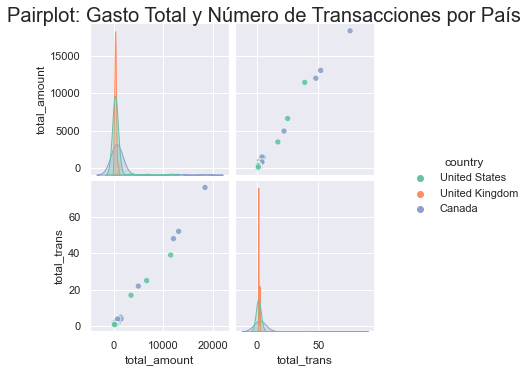

In [343]:
bubble_chart_grouped = bubble_chart_grouped.dropna(subset=['total_amount', 'total_trans'])

plt.figure(figsize=(80, 40))
sns.pairplot(
    data=bubble_chart_grouped,
    vars=['total_amount', 'total_trans'],
    hue='country',
    palette='Set2',
    plot_kws={'alpha': 0.9}
)

plt.suptitle('Pairplot: Gasto Total y Número de Transacciones por País', y=1.02, fontsize=20)
plt.show()
#vemos el gasto total de cada usuario en comparación con el número de transacciones totales de cada usuario por país